# Vehicle Detection

## Import Library

In [6]:
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import numpy as np

# ------

import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import load_model
from keras.preprocessing import image


## Load Data

In [54]:
VEHICLES_DIR = r'D:\A.I\Remove_Background\data\outside'
NON_VEHICLES_DIR = r"D:\A.I\Remove_Background\data\inside"

In [55]:
vehicles_image_names = os.listdir(VEHICLES_DIR)
non_vehicles_image_names = os.listdir(NON_VEHICLES_DIR)

In [56]:
print('TOTAL NO. OF VEHICLE IMAGES:', len(vehicles_image_names))
print('TOTAL NO. OF NON-VEHICLE IMAGES:', len(non_vehicles_image_names))

TOTAL NO. OF VEHICLE IMAGES: 2126
TOTAL NO. OF NON-VEHICLE IMAGES: 1276


In [57]:
print(vehicles_image_names[:10])
print(non_vehicles_image_names[:10])

['output10001880349014.png', 'output10010633932138.png', 'output10012122192599.png', 'output10015084976453.png', 'output10018297494703.png', 'output10022277357124.png', 'output10027507316000.png', 'output10029693693464.png', 'output10031658095490.png', 'output10039377541096.png']
['output10002873365488.png', 'output10004014733385.png', 'output10006324306445.png', 'output10013214244996.png', 'output10016804134306.png', 'output10023310223804.png', 'output10023814081091.png', 'output10030923027067.png', 'output10031126813389.png', 'output10031496071543.png']


## Create Train Test Directory

In [58]:
BASE_DIR = '../tmp/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VEHICLES_TRAIN_DIR = os.path.join(TRAIN_DIR, 'vehicles')
NON_VEHICLES_TRAIN_DIR = os.path.join(TRAIN_DIR, 'non-vehicles')
VEHICLES_TEST_DIR = os.path.join(TEST_DIR, 'vehicles')
NON_VEHICLES_TEST_DIR = os.path.join(TEST_DIR, 'non-vehicles')

In [59]:
TRAIN_SIZE = 0.8

In [60]:
train_vehicles, test_vehicles = train_test_split(
    vehicles_image_names, train_size=TRAIN_SIZE, shuffle=True, random_state=1
)

train_non_vehicles, test_non_vehicles = train_test_split(
    non_vehicles_image_names, train_size=TRAIN_SIZE, shuffle=True, random_state=1
)

In [71]:
print('TOTAL NO. OF TRAIN VEHICLE IMAGES:', len(train_vehicles))
print('TOTAL NO. OF TRAIN NON-VEHICLE IMAGES:', len(train_non_vehicles))

print('TOTAL NO. OF TEST VEHICLE IMAGES:', len(test_vehicles))
print('TOTAL NO. OF TEST NON-VEHICLE IMAGES:', len(test_non_vehicles))

TOTAL NO. OF TRAIN VEHICLE IMAGES: 1700
TOTAL NO. OF TRAIN NON-VEHICLE IMAGES: 1020
TOTAL NO. OF TEST VEHICLE IMAGES: 426
TOTAL NO. OF TEST NON-VEHICLE IMAGES: 256


In [72]:
def move_images(image_list, old_dir_path, new_dir_path):
    if not os.path.exists(new_dir_path):
        os.makedirs(new_dir_path)
    
    for file_name in image_list:
        shutil.copy(
            os.path.join(old_dir_path, file_name),
            os.path.join(new_dir_path, file_name)
        )
    print(f'{len(image_list)} IMAGES COPIED TO {new_dir_path}')

In [73]:
move_images(train_vehicles, VEHICLES_DIR, VEHICLES_TRAIN_DIR)
move_images(train_non_vehicles, NON_VEHICLES_DIR, NON_VEHICLES_TRAIN_DIR)

move_images(test_vehicles, VEHICLES_DIR, VEHICLES_TEST_DIR)
move_images(test_non_vehicles, NON_VEHICLES_DIR, NON_VEHICLES_TEST_DIR)

1700 IMAGES COPIED TO ../tmp/train\vehicles
1020 IMAGES COPIED TO ../tmp/train\non-vehicles
426 IMAGES COPIED TO ../tmp/test\vehicles
256 IMAGES COPIED TO ../tmp/test\non-vehicles


In [74]:
len(os.listdir(VEHICLES_TRAIN_DIR))

1700

## Preprocessing

In [75]:
IMG_SIZE = 256

In [76]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    class_mode='binary'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary'
)

Found 2720 images belonging to 2 classes.
Found 682 images belonging to 2 classes.


## Model

In [77]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D(2, 2),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 246017    
Total params: 265,409
Trainable params: 265,409
Non-trainable params: 0
________________________________________________

## Model Train

In [78]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)

model_path = 'vehicle_detection.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    save_best_only=True
)

In [79]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=40,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/40
85/85 [==============================] - 12s 127ms/step - loss: 0.5352 - accuracy: 0.8029 - val_loss: 0.2620 - val_accuracy: 0.8798
Epoch 2/40
85/85 [==============================] - 5s 54ms/step - loss: 0.2080 - accuracy: 0.9143 - val_loss: 0.1901 - val_accuracy: 0.9311
Epoch 3/40
85/85 [==============================] - 5s 55ms/step - loss: 0.1194 - accuracy: 0.9574 - val_loss: 0.1837 - val_accuracy: 0.9194
Epoch 4/40
85/85 [==============================] - 5s 55ms/step - loss: 0.0538 - accuracy: 0.9835 - val_loss: 0.1659 - val_accuracy: 0.9355
Epoch 5/40
85/85 [==============================] - 5s 54ms/step - loss: 0.0205 - accuracy: 0.9952 - val_loss: 0.1909 - val_accuracy: 0.9326
Epoch 6/40
85/85 [==============================] - 5s 56ms/step - loss: 0.0131 - accuracy: 0.9982 - val_loss: 0.1840 - val_accuracy: 0.9428
Epoch 7/40
85/85 [==============================] - 5s 56ms/step - loss: 0.0071 - accuracy: 0.9989 - val_loss: 0.1826 - val_accuracy: 0.9413
Epoch 8/40


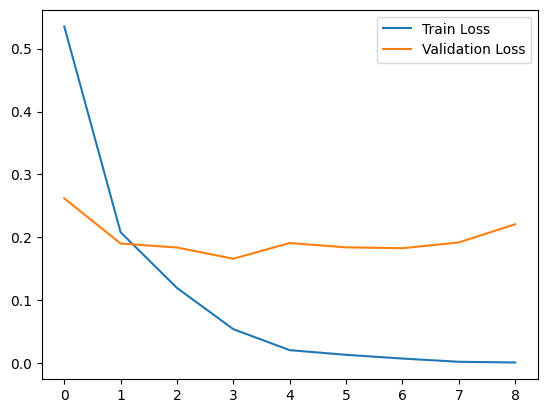

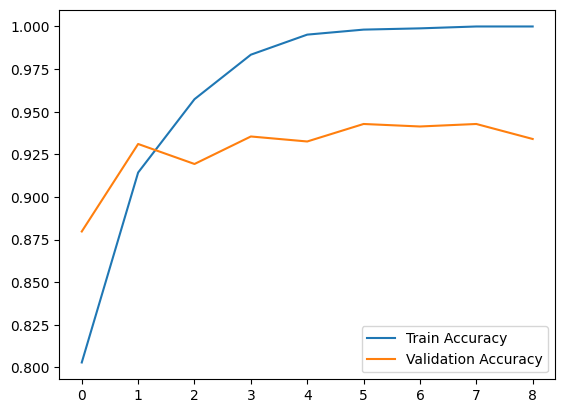

In [80]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

## Save Model

In [81]:
saved_model = tf.keras.models.load_model(model_path)
saved_model.evaluate(test_generator)

22/22 [==============================] - 1s 35ms/step - loss: 0.1659 - accuracy: 0.9355


[0.16587750613689423, 0.9354838728904724]

In [87]:
pre_mod = tf.keras.models.load_model(model_path)
root = r'D:\A.I\Remove_Background\data\inside'
# for item in os.listdir(root):
#     full = os.path.join(root, item)
#     img = image.load_img(full, target_size=(256, 256))
#     plt.imshow(img)
#     img = np.expand_dims(img, axis=0)
#     result = pre_mod.predict(img)
#     print(full)
#     print(result)
#     print('<_____________>')

# ________________________________

img = image.load_img(r"D:\Data\Image_Bounded\ACURA Legend Coupe 1990 - 1995\444.jpg", target_size=(256, 256))
img = np.expand_dims(img, axis=0)
result = pre_mod.predict(img)
print(result)
print('<_____________>')

[[0.]]
<_____________>
